<a href="https://colab.research.google.com/github/livgimenes/climate-misinf-eeps1720/blob/main/model_training_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A note: I used this one notebook to test a bunch of variations of this model - I modified the model itself and reran the notebook each time rather than defining separate models to begin with so only the most recent model I was working on is actually visible here!

Disclaimer: some of this code was provided by Coan et al from their paper "Computer-assisted classification of contrarian claims about climate change" (https://doi.org/10.1038/s41598-021-01714-4)


In [ ]:
# Install/load the required packages
!pip install simpletransformers
import pandas as pd
import re
import unicodedata
import time
from simpletransformers.classification import ClassificationModel
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [2]:
def f1_multiclass_macro(labels, preds):
    return f1_score(labels, preds, average='macro')
def f1_multiclass_micro(labels, preds):
    return f1_score(labels, preds, average='micro')
def f1_multiclass_weighted(labels, preds):
    return f1_score(labels, preds, average='weighted')
def f1_class(labels, preds):
    return f1_score(labels, preds, average=None)
def precision(labels, preds):
    return precision_score(labels, preds, average='macro')
def recall(labels, preds):
    return recall_score(labels, preds, average='macro')

# PRE PROCESSING
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()

In [3]:
# Load DATA


train = pd.read_csv('/content/training.csv')
valid = pd.read_csv('/content/validation.csv')
test = pd.read_csv('/content/test.csv')

train['text'] = train['text'].astype(str).apply(denoise_text)
valid['text'] = valid['text'].astype(str).apply(denoise_text)
test['text'] = test['text'].astype(str).apply(denoise_text)

label_encoder = LabelEncoder()

train['labels'] = label_encoder.fit_transform(train.claim)
valid['labels'] = label_encoder.fit_transform(valid.claim)
test['labels'] = label_encoder.fit_transform(test.claim)

In [ ]:
print(round(train.labels.value_counts(normalize=True),2))
weights = compute_class_weight(class_weight='balanced', classes=train.labels.unique(), y=train.labels)
weights = [*weights]
print(weights)

In [ ]:
model = ClassificationModel('roberta', 'roberta-large', 
                            weight = weights,
                            num_labels = 6,
                            args={'reprocess_input_data': True, 
                                  'overwrite_output_dir': True,
                                  'output_dir': 'models/new_model/',
                                  'best_model_dir': 'models/new_model/best_model/',
                                  # Hyperparameters
                                  'train_batch_size': 6,
                                  'num_train_epochs': 3, 
                                  'learning_rate': 1e-5,
                                  # Text processing
                                  'max_seq_length': 256,
                                  'sliding_window': True,
                                  'stride': 0.6,
                                  'do_lower_case': False,
                                  # Evaluation
                                  'evaluate_during_training': True,
                                  'evaluate_during_training_verbose': True,
                                  'evaluate_during_training_steps': -1,
                                  })

# Train and evaluate the model
model.train_model(train, eval_df = valid,
                  f1_macro = f1_multiclass_macro, 
                  f1_micro = f1_multiclass_micro, 
                  f1_weighted = f1_multiclass_weighted, 
                  acc = accuracy_score, 
                  f1_class = f1_class)

In [ ]:
# Evaluate the classifier performance on the validation data
result, model_outputs, wrong_predictions = model.eval_model(valid, 
                                                            f1_macro = f1_multiclass_macro,
                                                            precision = precision, 
                                                            recall = recall,
                                                            acc = accuracy_score,
                                                            f1_micro = f1_multiclass_micro, 
                                                            f1_weighted = f1_multiclass_weighted, 
                                                            f1_class = f1_class)

print('\n\nThese are the results when testing the model on the validation data set:\n')
print(result)

In [ ]:
# Evaluate the classifier performance on the testing data
result_test, model_outputs_test, wrong_predictions_test = model.eval_model(test, 
                                                                           f1_macro = f1_multiclass_macro,
                                                                           precision = precision, 
                                                                           recall = recall,
                                                                           acc = accuracy_score,
                                                                           f1_micro = f1_multiclass_micro, 
                                                                           f1_weighted = f1_multiclass_weighted,
                                                                           f1_class = f1_class)
print('\n\nThese are the results when testing the model on the testing data set:\n')
print(result_test)

## Comparing Model Results

Code to generate some of the figures in the paper

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

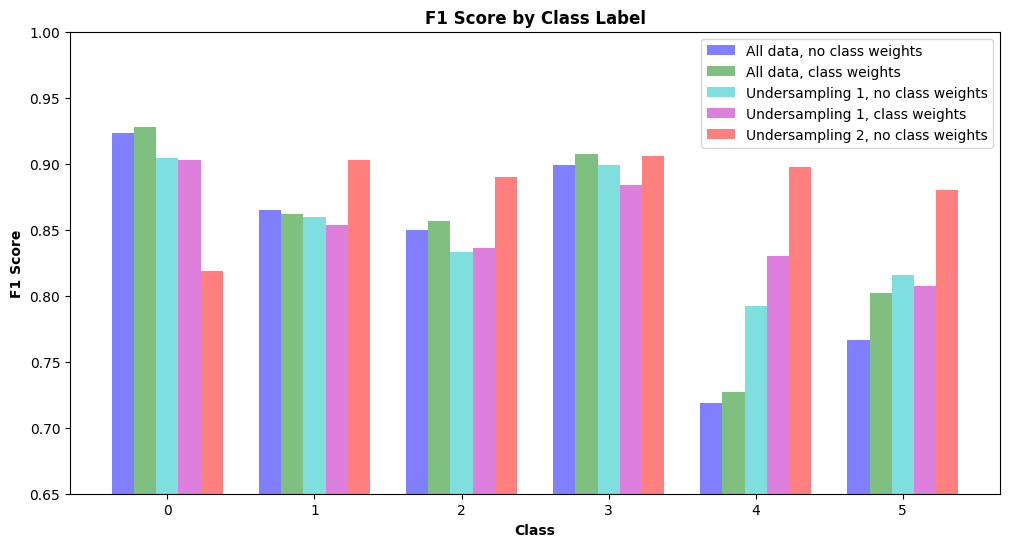

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

orig_data_no_weights = [0.92320306, 0.86486486, 0.84955752, 0.89915966, 0.71864407,
       0.76679842]
orig_data_weights = [0.92819518, 0.86166008, 0.85628743, 0.90763052, 0.72727273,
       0.80201765]
one_fifth_data_no_weights = [0.81900452, 0.90310078, 0.89014085, 0.90612245, 0.89772727, 0.88]
equal_data_no_weights = [0.90461804, 0.85984848, 0.83333333, 0.89878543, 0.79190751,
       0.81572482]
equal_data_weights = [0.90263955, 0.85380117, 0.83615819, 0.88372093, 0.83008357,
       0.80745342]

pos = np.arange(len(orig_data_no_weights))
width = 0.15

fig, ax = plt.subplots(figsize=(12,6))
plt.ylim(0.65, 1)
ax.bar(pos, orig_data_no_weights, width, alpha=0.5, color='b', label='All data, no class weights')
ax.bar(pos + width, orig_data_weights, width, alpha=0.5, color='g', label='All data, class weights')
ax.bar(pos + 2*width, equal_data_no_weights, width, alpha=0.5, color='c', label='Undersampling 1, no class weights')
ax.bar(pos + 3*width, equal_data_weights, width, alpha=0.5, color='m', label='Undersampling 1, class weights')
ax.bar(pos + 4*width, one_fifth_data_no_weights, width, alpha=0.5, color='r', label='Undersampling 2, no class weights')

ax.set_ylabel('F1 Score', fontweight='heavy')
ax.set_xlabel('Class', fontweight='heavy')
ax.set_title('F1 Score by Class Label', fontweight='heavy')
ax.set_xticks(pos + 2*width)
ax.set_xticklabels(('0', '1', '2', '3', '4', '5'))
ax.legend()

# Show the plot
plt.savefig("f1_by_class.png", dpi=300)
files.download("f1_by_class.png") 


Multi class vs Binary

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

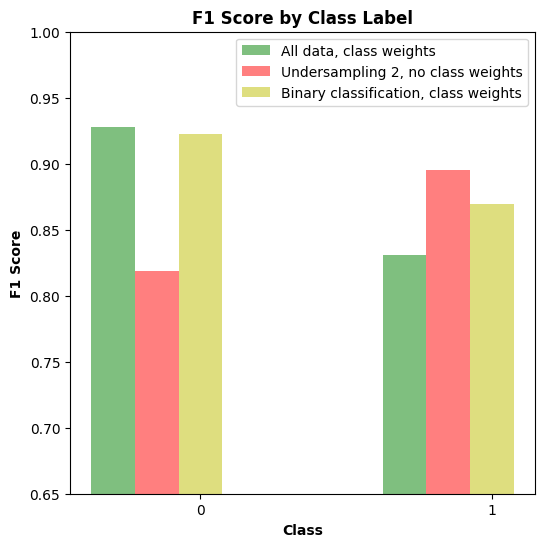

In [3]:
orig_data_no_weights_valid = 0.92320306
orig_data_no_weights_avg = np.mean([0.86486486, 0.84955752, 0.89915966, 0.71864407,
       0.76679842])
orig_data_weights_valid = 0.92819518
orig_data_weights_avg = np.mean([0.86166008, 0.85628743, 0.90763052, 0.72727273,
       0.80201765])
one_fifth_data_no_weights_valid = 0.81900452
one_fifth_data_no_weights_avg = np.mean([0.90310078, 0.89014085, 0.90612245, 0.89772727, 0.88])
equal_data_no_weights_valid = 0.90461804
equal_data_no_weights_avg = np.mean([0.85984848, 0.83333333, 0.89878543, 0.79190751,
       0.81572482])
equal_data_weights_valid = 0.90263955
equal_data_weights_avg = np.mean([0.85380117, 0.83615819, 0.88372093, 0.83008357,
       0.80745342])
binary_valid = 0.92231677
binary_misinf = 0.86928406

pos = np.arange(2)
width = 0.15

fig, ax = plt.subplots(figsize=(6,6))
plt.ylim(0.65, 1)
ax.bar(pos, [orig_data_weights_valid, orig_data_weights_avg], width, alpha=0.5, color='g', label='All data, class weights')
ax.bar(pos + 1*width, [one_fifth_data_no_weights_valid, one_fifth_data_no_weights_avg], width, alpha=0.5, color='r', label='Undersampling 2, no class weights')
ax.bar(pos + 2*width, [binary_valid, binary_misinf], width, alpha=0.5, color='y', label='Binary classification, class weights')

ax.set_ylabel('F1 Score', fontweight='heavy')
ax.set_xlabel('Class', fontweight='heavy')
ax.set_title('F1 Score by Class Label', fontweight='heavy')
ax.set_xticks(pos + 2*width)
ax.set_xticklabels(('0', '1'))
ax.legend()

# Show the plot
plt.savefig("f1_binary.png", dpi=300)
files.download("f1_binary.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

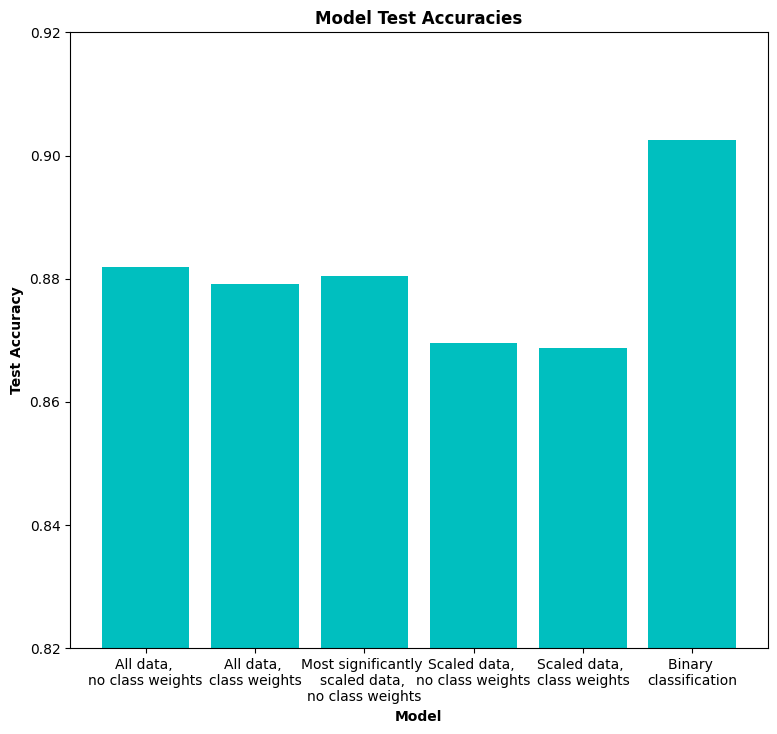

In [ ]:
orig_data_no_weights_test_acc = 0.8818870523415978
orig_data_weights_test_acc = 0.8791322314049587
one_fifth_data_no_weights_test_acc = 0.8804347826086957
equal_data_no_weights_test_acc = 0.8695652173913043
equal_data_weights_test_acc = 0.8686956521739131   
binary_class = 0.9025482093663911
plt.figure(figsize=(9, 8))
plt.ylim(0.82, 0.92)
x = np.arange(6)
plt.bar(["All data, \nno class weights", "All data, \nclass weights", "Most significantly \nscaled data, \nno class weights", 'Scaled data, \nno class weights', 'Scaled data, \nclass weights', 'Binary \nclassification'], [orig_data_no_weights_test_acc, orig_data_weights_test_acc, one_fifth_data_no_weights_test_acc, equal_data_no_weights_test_acc, equal_data_weights_test_acc, binary_class], color='c')
plt.ylabel('Test Accuracy', fontweight='heavy')
plt.xlabel('Model', fontweight='heavy')
plt.title('Model Test Accuracies', fontweight='heavy')

plt.savefig("test_accs.png", dpi=300)
files.download("test_accs.png") 

## Sanity Checks: Climate Skeptics Dataset

In [ ]:
import ast
skeptics_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/climate_skeptics_all.csv?token=GHSAT0AAAAAAB5UTNPL7X6Y4HZKIFZ53EKUZCT2MQQ')

def join_lists(lst):
    return ' '.join(ast.literal_eval(lst))

skeptics_data['claim'] = skeptics_data['claim'].apply(join_lists).apply(denoise_text)

preds = model.predict(skeptics_data['claim'])

In [ ]:
non_zero = preds[0][preds[0] != 0]
len(non_zero)

In [ ]:
science_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/climate_scientist_all.csv?token=GHSAT0AAAAAAB5UTNPLVZU4IHUV65CA6DMUZCT2ODQ')
science_data['claim'] = science_data['claim'].apply(join_lists).apply(denoise_text)
preds_real = model.predict(science_data['claim'])

In [ ]:
non_zero = preds_real[0][preds_real[0] != 0]
len(non_zero)

In [ ]:
political_sub_data = pd.read_csv('https://raw.githubusercontent.com/livgimenes/climate-misinf-eeps1720/main/data/clean/political_posts.csv?token=GHSAT0AAAAAAB5UTNPLYZP2V752PSJK6MACZCT2O7Q')
political_sub_data['claim'] = political_sub_data['claim'].apply(join_lists).apply(denoise_text)
poli_preds = model.predict(political_sub_data['claim'])
political_sub_data['prediction'] = poli_preds[0]


In [ ]:
political_sub_data[political_sub_data['prediction'] != 0]

Corroborating results with second model

In [24]:
train2 = pd.read_csv('/content/training2.csv')
valid2 = pd.read_csv('/content/validation.csv')
test2 = pd.read_csv('/content/test.csv')

train2['text'] = train2['text'].astype(str).apply(denoise_text)
valid2['text'] = valid2['text'].astype(str).apply(denoise_text)
test2['text'] = test2['text'].astype(str).apply(denoise_text)

label_encoder = LabelEncoder()

train2['labels'] = label_encoder.fit_transform(train2.claim)
valid2['labels'] = label_encoder.fit_transform(valid2.claim)
test2['labels'] = label_encoder.fit_transform(test2.claim)

In [ ]:
weights = compute_class_weight(class_weight=None, classes=train2.labels.unique(), y=train2.labels)
weights = [*weights]

model2 = ClassificationModel('roberta', 'roberta-large', 
                            weight = weights,
                            num_labels = 6,
                            args={'reprocess_input_data': True, 
                                  'overwrite_output_dir': True,
                                  'output_dir': 'models/new_model/',
                                  'best_model_dir': 'models/new_model/best_model/',
                                  # Hyperparameters
                                  'train_batch_size': 6,
                                  'num_train_epochs': 3, 
                                  'learning_rate': 1e-5,
                                  # Text processing
                                  'max_seq_length': 256,
                                  'sliding_window': True,
                                  'stride': 0.6,
                                  'do_lower_case': False,
                                  # Evaluation
                                  'evaluate_during_training': True,
                                  'evaluate_during_training_verbose': True,
                                  'evaluate_during_training_steps': -1,
                                  })

# Train and evaluate the model
model2.train_model(train2, eval_df = valid2,
                  f1_macro = f1_multiclass_macro, 
                  f1_micro = f1_multiclass_micro, 
                  f1_weighted = f1_multiclass_weighted, 
                  acc = accuracy_score, 
                  f1_class = f1_class)

In [ ]:
result_test, model_outputs_test, wrong_predictions_test = model2.eval_model(test2, 
                                                                           f1_macro = f1_multiclass_macro,
                                                                           precision = precision, 
                                                                           recall = recall,
                                                                           acc = accuracy_score,
                                                                           f1_micro = f1_multiclass_micro, 
                                                                           f1_weighted = f1_multiclass_weighted,
                                                                           f1_class = f1_class)
print('\n\nThese are the results when testing the model on the testing data set:\n')
print(result_test)

In [ ]:
poli_preds_2 = model2.predict(political_sub_data['claim'])
political_sub_data['prediction2'] = poli_preds_2[0]

In [35]:
political_sub_data['final_pred'] = np.where((political_sub_data['prediction'] == 0) | (political_sub_data['prediction2'] == 0), 0, political_sub_data['prediction'])

In [ ]:
import matplotlib.pyplot as plt
# create a pivot table to count the number of claims for each subreddit and label
pivot = pd.pivot_table(political_sub_data, values='claim', index='subreddit', columns='final_pred', aggfunc='count')

# create a stacked bar chart to show the distribution of claim labels by subreddit
pivot.plot(kind='bar', stacked=False)

# add labels and title to the chart
plt.xlabel('Subreddit')
plt.ylabel('Number of Claims')
plt.title('Distribution of Claim Labels by Subreddit')
plt.show()

In [ ]:
poli_misinf = political_sub_data[political_sub_data['final_pred'] != 0]
pivot2 = pd.pivot_table(poli_misinf, values='claim', index='subreddit', columns='final_pred', aggfunc='count')

# create a stacked bar chart to show the distribution of claim labels by subreddit
pivot2.plot(kind='bar', stacked=False)

# add labels and title to the chart
plt.xlabel('Subreddit')
plt.ylabel('Number of Claims')
plt.title('Distribution of Claim Labels by Subreddit')
plt.show()

In [ ]:
pivot = pivot.fillna(0)
pivot